In [1]:
"""
VAE Baseline for Quantum Hackathon (Problem Statement 3)
Author: Varun E
Description:
  - Trains a Variational Autoencoder (VAE) on MNIST.
  - Saves reconstructions and sample generations.
  - Provides clean baseline metrics before adding quantum components.
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
import os
import numpy as np

# -----------------------------
# 🔧 Configuration
# -----------------------------
BATCH_SIZE = 128
EPOCHS = 20
LR = 1e-3
LATENT_DIM = 20
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
OUT_DIR = "results_vae"
os.makedirs(OUT_DIR, exist_ok=True)

# -----------------------------
# 📦 Data loading
# -----------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# -----------------------------
# 🧠 VAE Model Definition
# -----------------------------
class VAE(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(28*28, 400)
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)

        # Decoder
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 28*28)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc_mu(h1), self.fc_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.tanh(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28*28))
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar


# -----------------------------
# ⚙️ Loss Function
# -----------------------------
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction + KL divergence losses summed over all elements
    recon_loss = F.mse_loss(recon_x, x.view(-1, 28*28), reduction='sum')
    # KL Divergence: measure how latent distribution deviates from N(0,1)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss


# -----------------------------
# 🚀 Training Function
# -----------------------------
def train(epoch, model, optimizer):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(DEVICE)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    avg_loss = train_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}: Average training loss = {avg_loss:.4f}")
    return avg_loss


# -----------------------------
# 🧪 Testing Function
# -----------------------------
def test(epoch, model):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(DEVICE)
            recon_batch, mu, logvar = model(data)
            test_loss += vae_loss(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([
                    data[:n],
                    recon_batch.view(BATCH_SIZE, 1, 28, 28)[:n]
                ])
                save_image(comparison.cpu(),
                           f"{OUT_DIR}/reconstruction_epoch{epoch}.png", nrow=n)
    test_loss /= len(test_loader.dataset)
    print(f"====> Test set loss: {test_loss:.4f}")
    return test_loss


# -----------------------------
# 🏋️ Main Training Loop
# -----------------------------
def main():
    model = VAE().to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    train_losses, test_losses = [], []

    for epoch in range(1, EPOCHS + 1):
        tr_loss = train(epoch, model, optimizer)
        te_loss = test(epoch, model)
        train_losses.append(tr_loss)
        test_losses.append(te_loss)

        # Sample from latent space
        with torch.no_grad():
            sample = torch.randn(64, LATENT_DIM).to(DEVICE)
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 28, 28),
                       f"{OUT_DIR}/sample_epoch{epoch}.png")

    print("Training complete. Results saved in 'results_vae/'")

    # Optionally save model
    torch.save(model.state_dict(), os.path.join(OUT_DIR, "vae_mnist.pt"))

if __name__ == "__main__":
    main()


 22%|██▏       | 2.16M/9.91M [02:50<10:12, 12.6kB/s]
100%|██████████| 9.91M/9.91M [00:02<00:00, 4.47MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 109kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.04MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 76.9kB/s]


Epoch 1: Average training loss = 123.3096
====> Test set loss: 85.7028
Epoch 2: Average training loss = 82.3623
====> Test set loss: 78.2669
Epoch 3: Average training loss = 77.2281
====> Test set loss: 75.2664
Epoch 4: Average training loss = 74.6483
====> Test set loss: 72.9513
Epoch 5: Average training loss = 73.0096
====> Test set loss: 71.6111
Epoch 6: Average training loss = 71.8369
====> Test set loss: 70.8388
Epoch 7: Average training loss = 71.0049
====> Test set loss: 70.3327
Epoch 8: Average training loss = 70.2981
====> Test set loss: 69.2608
Epoch 9: Average training loss = 69.7120
====> Test set loss: 69.1753
Epoch 10: Average training loss = 69.1846
====> Test set loss: 68.8874
Epoch 11: Average training loss = 68.7670
====> Test set loss: 68.2804
Epoch 12: Average training loss = 68.4243
====> Test set loss: 68.1481
Epoch 13: Average training loss = 68.1089
====> Test set loss: 67.9505
Epoch 14: Average training loss = 67.7446
====> Test set loss: 67.5203
Epoch 15: Aver

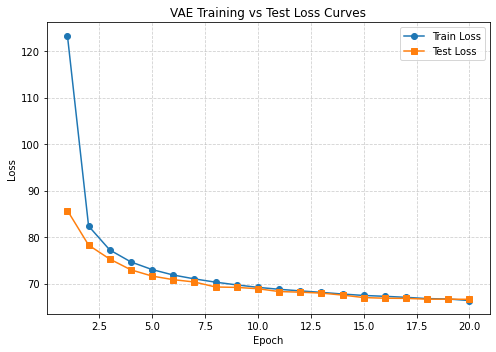

In [2]:
import matplotlib.pyplot as plt

# Loss values copied from your logs
train_loss = [123.3096,82.3623,77.2281,74.6483,73.0096,71.8369,71.0049,
               70.2981,69.7120,69.1846,68.7670,68.4243,68.1089,67.7446,
               67.4404,67.2555,67.0394,66.7653,66.6764,66.3444]

test_loss = [85.7028,78.2669,75.2664,72.9513,71.6111,70.8388,70.3327,
              69.2608,69.1753,68.8874,68.2804,68.1481,67.9505,67.5203,
              66.9865,66.8462,66.8161,66.6407,66.6423,66.6126]

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(7,5))
plt.plot(epochs, train_loss, marker='o', label='Train Loss')
plt.plot(epochs, test_loss, marker='s', label='Test Loss')
plt.title("VAE Training vs Test Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("results_vae/vae_loss_from_logs.png", dpi=200)
plt.show()
